# **Classification and Sentiment Analysis**

***

## **1. Poker Hand Classification**

- Pokerhand Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/poker/
  - new link: https://archive.ics.uci.edu/ml/datasets/Poker+Hand
- Pay attention to class distribution.
- Implement early stopping in model
  - Provide visualization of training and cross validation loss at each epoch
- Provide confusion matrix and F1 score for the test data
- The output of the model will be the probabilities of each class

Sentiment Analysis**

(insert)

***

## **1. Poker Hand Classification**

- Pokerhand Dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/poker/
  - new link: https://archive.ics.uci.edu/ml/datasets/Poker+Hand
- Pay attention to class distribution.
- Implement early stopping in model
  - Provide visualization of training and cross validation loss at each epoch
- Provide confusion matrix and F1 score for the test data
- The output of the model will be the probabilities of each class

In [23]:
# Import Necessary Libraries
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from textblob import TextBlob
from transformers import BertModel, BertTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization, LeakyReLU
tf.random.set_seed(1)

In [24]:
# Dataset column names
columns = ['S1','C1','S2','C2','S3','C3','S4','C4','S5','C5','Class']

# Load dataset
dfPoker = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data", header=None, names=columns)

# Display first ten rows
print("DATASET PREVIEW:")
dfPoker.head(10)

DATASET PREVIEW:


,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Class
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9
5,1,2,1,4,1,5,1,3,1,6,8
6,1,9,1,12,1,10,1,11,1,13,8
7,2,1,2,2,2,3,2,4,2,5,8
8,3,5,3,6,3,9,3,7,3,8,8
9,4,1,4,4,4,2,4,3,4,5,8


In [25]:
# Dataset Information
print("DATASET INFORMATION:")
dfPoker.info()

DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25010 entries, 0 to 25009
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   S1      25010 non-null  int64
 1   C1      25010 non-null  int64
 2   S2      25010 non-null  int64
 3   C2      25010 non-null  int64
 4   S3      25010 non-null  int64
 5   C3      25010 non-null  int64
 6   S4      25010 non-null  int64
 7   C4      25010 non-null  int64
 8   S5      25010 non-null  int64
 9   C5      25010 non-null  int64
 10  Class   25010 non-null  int64
dtypes: int64(11)
memory usage: 2.1 MB


In [26]:
# Check for duplicate rows
duplicateRows = dfPoker.duplicated().sum()
print("DUPLICATE ROWS:", duplicateRows)

# Check for missing values
print("\nMISSING VALUES:")
print(dfPoker.isnull().sum())

DUPLICATE ROWS: 2

MISSING VALUES:
S1       0
C1       0
S2       0
C2       0
S3       0
C3       0
S4       0
C4       0
S5       0
C5       0
Class    0
dtype: int64


In [27]:
# Remove duplicate rows
dfPoker.drop_duplicates(inplace=True)
duplicateRows = dfPoker.duplicated().sum()
print("DUPLICATE ROWS:", duplicateRows)

# Unique values in column 'Class'
print("\nUNIQUE 'CLASS' VALUES:")
print(dfPoker['Class'].unique())

DUPLICATE ROWS: 0

UNIQUE 'CLASS' VALUES:
[9 8 1 0 4 3 2 5 6 7]


In [28]:
# Define X and y
X = dfPoker.drop('Class', axis=1)
y = dfPoker['Class']

# Split Dataset For Training And Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Compute Class Weights
print("CLASS WEIGHTS:")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

CLASS WEIGHTS:


{0: 0.20088362285370018,
 1: 0.23489491605025242,
 2: 2.0970649895178197,
 3: 4.752019002375297,
 4: 27.78611111111111,
 5: 45.46818181818182,
 6: 83.35833333333333,
 7: 400.12,
 8: 400.12,
 9: 400.12}

In [29]:
## Class Distribution
print("CLASS DISTRIBUTION:")
print(y_train.value_counts())

# Summary of Statistics
print("\nSUMMARY STATISTICS:")
dfPoker.describe()

CLASS DISTRIBUTION:
Class
0    9959
1    8517
2     954
3     421
4      72
5      44
6      24
9       5
7       5
8       5
Name: count, dtype: int64

SUMMARY STATISTICS:


,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5,Class
count,25008.000000,25008.000000,25008.000000,25008.000000,25008.000000,25008.000000,25008.000000,25008.000000,25008.000000,25008.000000,25008.000000
mean,2.508677,6.995242,2.497721,7.014475,2.510197,7.014036,2.496001,6.942658,2.497361,6.963092,0.621121
std,1.116484,3.749688,1.121803,3.766969,1.123149,3.745098,1.116009,3.747167,1.118768,3.741513,0.788385
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,0.000000
50%,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,1.000000
75%,4.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,3.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,9.000000


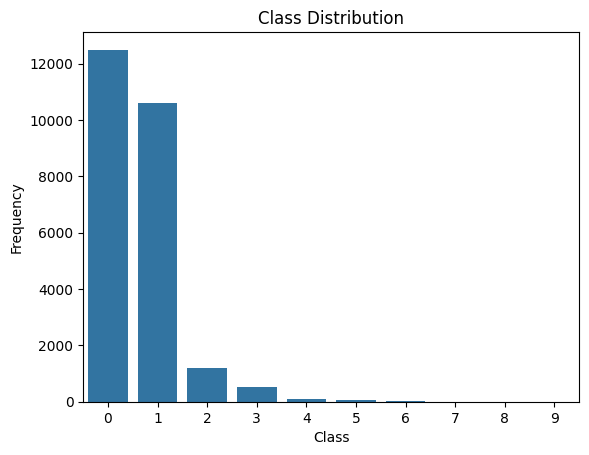

In [30]:
# Count Plot For Exploratory Data Analysis (EDA)
sns.countplot(x='Class', data=dfPoker)
plt.title("Class Distribution")
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

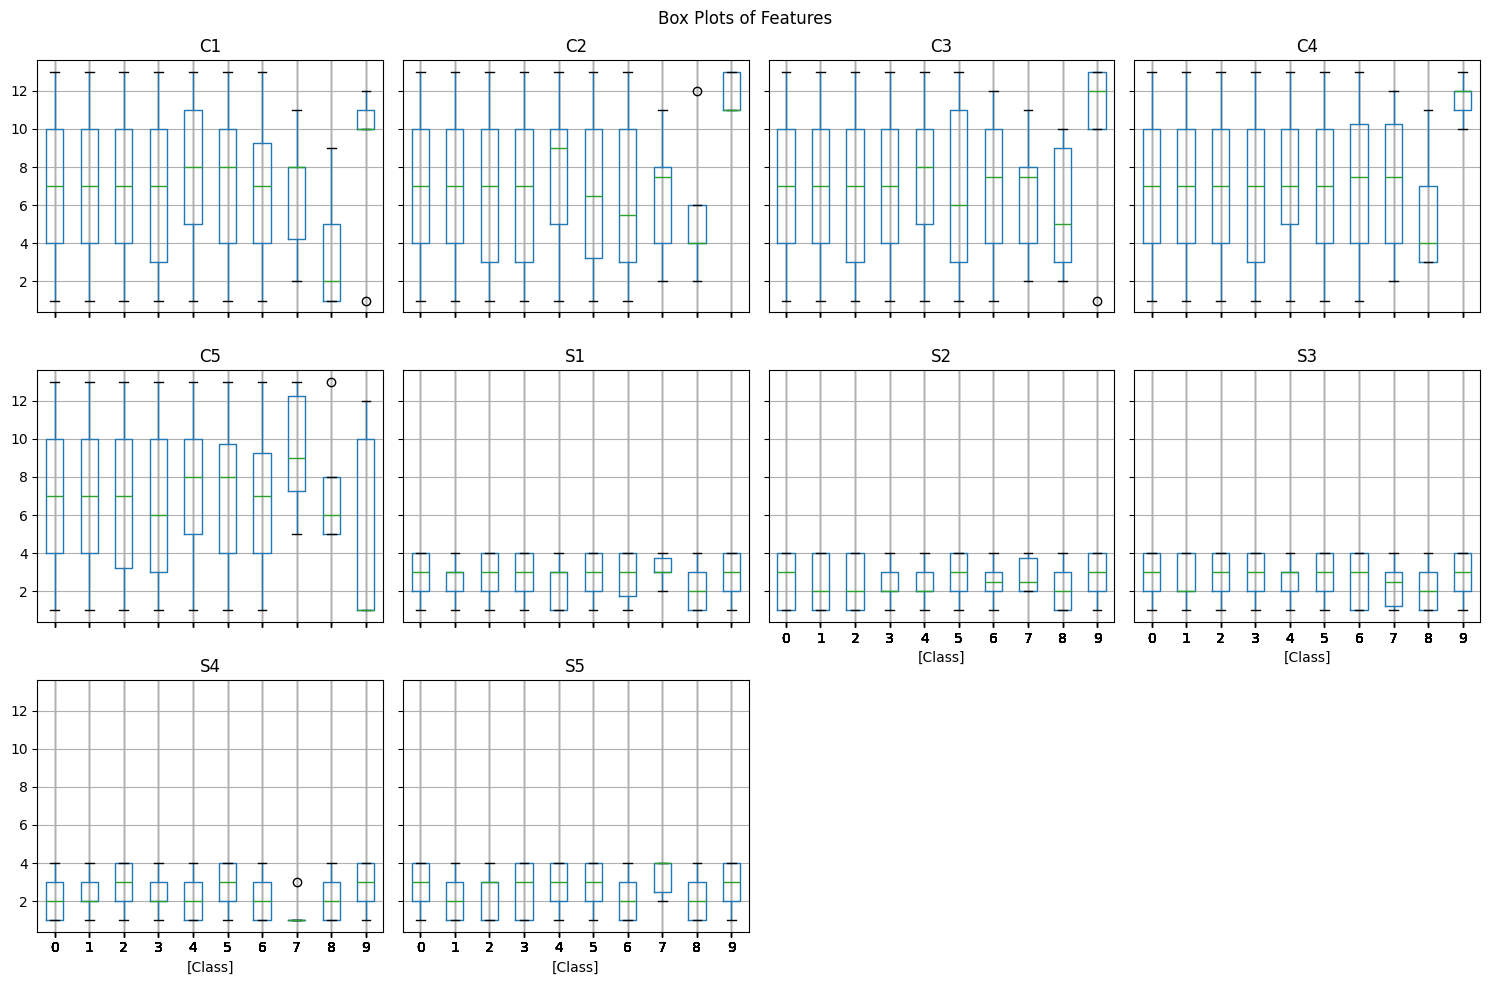

In [31]:
# Box Plots For Exploratory Data Analysis (EDA)
dfPoker.boxplot(by='Class', layout=(3, 4), figsize=(15, 10))
plt.suptitle('Box Plots of Features')
plt.tight_layout()
plt.show()

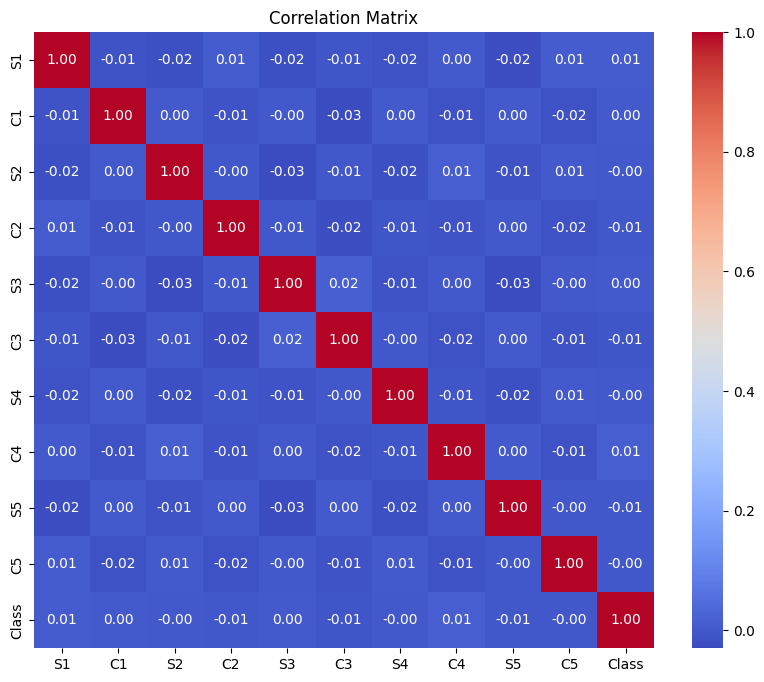

In [32]:
## Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = dfPoker.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [33]:
# Neural Network Model
tr_model = Sequential([InputLayer(input_shape=(X_train_scaled.shape[1],)),
                       Dense(2048, activation='relu'),
                       Dense(512, activation='relu'),
                       Dense(128, activation='relu'),
                       Dense(10, activation='softmax')])

# Model Compilation
tr_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
history = tr_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es], verbose=1)

/opt/anaconda3/envs/Tensor/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.4999 - loss: 1.0569 - val_accuracy: 0.5195 - val_loss: 0.9622
Epoch 2/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5442 - loss: 0.9611 - val_accuracy: 0.5262 - val_loss: 0.9525
Epoch 3/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5460 - loss: 0.9474 - val_accuracy: 0.5247 - val_loss: 0.9446
Epoch 4/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5525 - loss: 0.9396 - val_accuracy: 0.5277 - val_loss: 0.9396
Epoch 5/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5536 - loss: 0.9309 - val_accuracy: 0.5270 - val_loss: 0.9371
Epoch 6/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5582 - loss: 0.9222 - val_accuracy: 0.5282 - val_loss: 0.9371
Epoch 7/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5641 - loss: 0.9138 - val_accuracy: 0.5307 - val_loss: 0.9348
Epoch 8/100
501/501 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5701 - loss: 0.9010 -

In [34]:
# Neural Network Model
tr_model2 = Sequential([
    Dense(2048, input_dim=X_train_scaled.shape[1], activation=LeakyReLU(alpha=0.1), 
          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1024, activation=LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation=LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation=LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

# Model Compilation with Advanced Optimizer
tr_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model with Adjustments
history = tr_model2.fit(X_train_scaled, y_train, epochs=200, batch_size=64, 
                       validation_split=0.2, callbacks=[es], verbose=1)

/opt/anaconda3/envs/Tensor/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/envs/Tensor/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.0959 - loss: 5.6224 - val_accuracy: 0.0160 - val_loss: 5.0741
Epoch 2/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.1603 - loss: 5.2125 - val_accuracy: 0.3768 - val_loss: 4.6871
Epoch 3/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.2315 - loss: 4.9430 - val_accuracy: 0.4698 - val_loss: 4.5857
Epoch 4/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.3239 - loss: 4.7338 - val_accuracy: 0.5110 - val_loss: 4.4509
Epoch 5/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.3943 - loss: 4.5329 - val_accuracy: 0.5220 - val_loss: 4.2993
Epoch 6/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.4382 - loss: 4.3681 - val_accuracy: 0.5360 - val_loss: 4.1212
Epoch 7/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.4707 - loss: 4.1977 - val_accuracy: 0.5345 - val_loss: 3.9756
Epoch 8/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.4963 - loss: 4

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6054 - loss: 0.8593
TEST ACCURACY: 60.08%
TEST LOSS: 87.79%
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5803 - loss: 1.0286
TEST ACCURACY: 57.82%
TEST LOSS: 105.60%

LAST VALIDATION ACCURACY: 54.62%
LAST VALIDATION LOSS: 106.38%
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.69      0.64      0.66      2534
           1       0.54      0.64      0.59      2080
           2       0.25      0.09      0.13       252
           3       0.33      0.07      0.11        92
           4       0.00      0.00      0.00        21
           5       0.50      0.20      0.29        10
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0

    accuracy                           0.60      5002
   macro avg       0.26      0.18      0.2

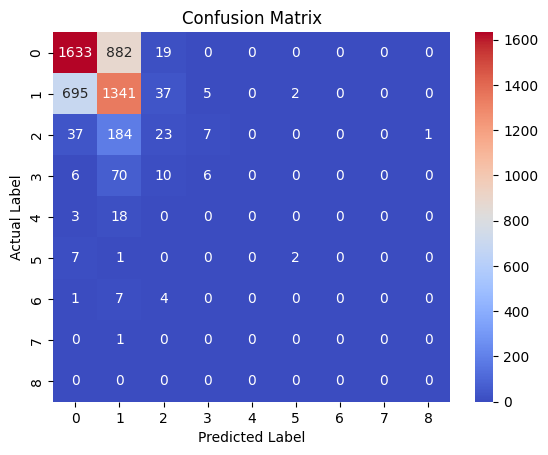

In [35]:
# Model Evaluation
test_loss, test_accuracy = tr_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"TEST ACCURACY: {test_accuracy*100:.2f}%")
print(f"TEST LOSS: {test_loss*100:.2f}%")

# Model Evaluation
test_loss, test_accuracy = tr_model2.evaluate(X_test_scaled, y_test, verbose=1)
print(f"TEST ACCURACY: {test_accuracy*100:.2f}%")
print(f"TEST LOSS: {test_loss*100:.2f}%")

# Summary of Model Performance
final_accuracy = history.history['val_accuracy'][-1]
final_loss = history.history['val_loss'][-1]
print(f"\nLAST VALIDATION ACCURACY: {final_accuracy*100:.2f}%")
print(f"LAST VALIDATION LOSS: {final_loss*100:.2f}%")

# Predictions
y_pred = tr_model.predict(X_test_scaled, verbose=1)
y_preds = np.argmax(y_pred, axis=1)

# Classification Report
report = classification_report(y_test, y_preds, zero_division=0)
print("\nCLASSIFICATION REPORT:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_preds)
print("CONFUSION MATRIX:")
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

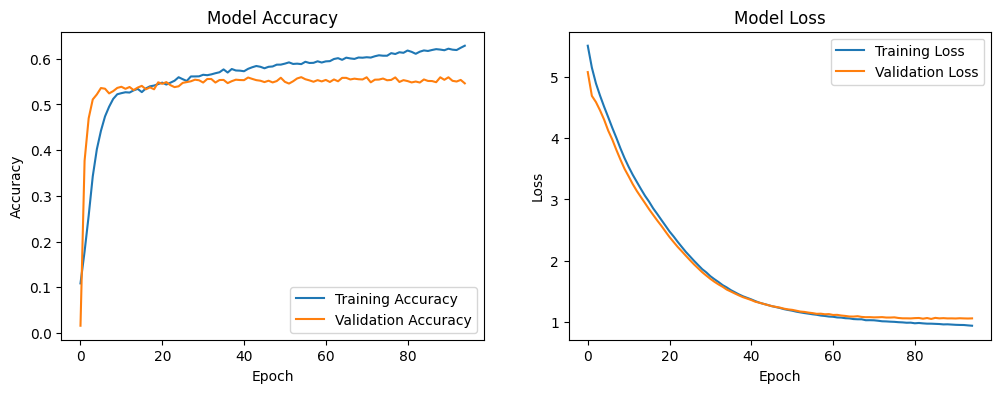

In [36]:
# Plot accuracy during training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss during training
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

***

## **2. Sentiment Analysis**

- Sentiment analysis involves determining the sentiment of text
- We will use a hotel review dataset that includes reviews and ratings
- Explore and clean the data
- Provide relevant visualizations
    - Implement stop words, stemming, or lemmatizing.
- Our goal is to train a model that can predict the number of stars based on the text

### *2.1 ~ Load Data*

- Either download the data and store it or use the Kaggle API to obtain the data from
    - https://www.kaggle.com/datasets/datafiniti/hotel-reviews
- Example:
    - If you use this method, you need to upload the JSON file with API Key to local Colab workspace.
        - https://www.kaggle.com/docs/api#authentication

In [37]:
# Load Dataset
dfReviews = pd.read_csv('../data/7282_1.csv')

# Display first ten rows
print("DATASET PREVIEW:")
dfReviews.head(10)

DATASET PREVIEW:


,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN
5,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel,NaN,A Traveler,NaN
6,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-06-10T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.,NaN,A Traveler,NaN
7,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-05-14T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,ottimo soggiorno e ottima sistemazione nei gio...,Lovely view out onto the lagoon. Excellent view.,NaN,A Traveler,NaN
8,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-09-14T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,3.0,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,G��nstige Lage,NaN,Doppeldecker,NaN
9,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-05-16T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Lidoen er perfekt til et par dages ro og afsla...,Ro og hygge,NaN,A Traveler,NaN


In [38]:
# Dataset Information
print("DATASET INFORMATION:")
dfReviews.info()

DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address               35912 non-null  object 
 1   categories            35912 non-null  object 
 2   city                  35912 non-null  object 
 3   country               35912 non-null  object 
 4   latitude              35826 non-null  float64
 5   longitude             35826 non-null  float64
 6   name                  35912 non-null  object 
 7   postalCode            35857 non-null  object 
 8   province              35912 non-null  object 
 9   reviews.date          35653 non-null  object 
 10  reviews.dateAdded     35912 non-null  object 
 11  reviews.doRecommend   0 non-null      float64
 12  reviews.id            0 non-null      float64
 13  reviews.rating        35050 non-null  float64
 14  reviews.text          35888 non-null  object 
 15

In [39]:
# Check for duplicate rows
duplicateRows = dfReviews.duplicated().sum()
print("DUPLICATE ROWS:", duplicateRows)

# Check for missing values
missingValues = dfReviews.isnull().sum()
print("\nNUMBER OF MISSING VALUES PER COLUMN:")
print(missingValues)

# Count total number of rows for each column
rowCounts = dfReviews.count()
print("\nNUMBER OF ROWS PER COLUMN:")
print(rowCounts)

DUPLICATE ROWS: 4

NUMBER OF MISSING VALUES PER COLUMN:
address                     0
categories                  0
city                        0
country                     0
latitude                   86
longitude                  86
name                        0
postalCode                 55
province                    0
reviews.date              259
reviews.dateAdded           0
reviews.doRecommend     35912
reviews.id              35912
reviews.rating            862
reviews.text               24
reviews.title            1626
reviews.userCity        19649
reviews.username           43
reviews.userProvince    18394
dtype: int64

NUMBER OF ROWS PER COLUMN:
address                 35912
categories              35912
city                    35912
country                 35912
latitude                35826
longitude               35826
name                    35912
postalCode              35857
province                35912
reviews.date            35653
reviews.dateAdded       35912
rev

### *2.2 ~ Data Exploration and Cleaning*

In [40]:
# Drop unnecessary columns
drop_columns = ['reviews.doRecommend', 'reviews.id', 'reviews.userCity', 'reviews.username', 'reviews.userProvince', 'city', 'country', 'latitude', 'longitude', 'name', 'postalCode', 'province']
dfReviews.drop(columns=drop_columns, inplace=True)

# Drop missing values
dfReviews.dropna(inplace=True)
missingValues = dfReviews.isnull().sum()
print("MISSING VALUES AFTER CLEANING:")
print(missingValues)

# Drop duplicate rows
dfReviews.drop_duplicates(inplace=True)
duplicateRows = dfReviews.duplicated().sum()
print("\nDUPLICATE ROWS AFTER CLEANING:", duplicateRows)

# Count total number of rows for each column
rowCounts = dfReviews.count()
print("NUMBER OF ROWS PER COLUMN:")
print(rowCounts)

MISSING VALUES AFTER CLEANING:
address              0
categories           0
reviews.date         0
reviews.dateAdded    0
reviews.rating       0
reviews.text         0
reviews.title        0
dtype: int64

DUPLICATE ROWS AFTER CLEANING: 0
NUMBER OF ROWS PER COLUMN:
address              34001
categories           34001
reviews.date         34001
reviews.dateAdded    34001
reviews.rating       34001
reviews.text         34001
reviews.title        34001
dtype: int64


In [41]:
# Check for unique values
unique_ratings = dfReviews['reviews.rating'].unique()
print("UNIQUE RATINGS:")
print(unique_ratings)

# Display first ten rows of cleaned dataset
print("\nCLEANED DATASET PREVIEW:")
dfReviews.head(10)

UNIQUE RATINGS:
[ 4.   5.   3.   1.   2.   0.   4.1  3.1  3.2  3.3  9.6 10.   8.3  8.8
  9.2  7.5  7.9  7.1  3.8  5.8  6.7  6.3  4.2  4.3  4.8  3.9  2.8  4.5
  4.4  4.7  1.5  4.9  4.6  3.7  3.4  5.4  2.5  6.   2.9  7.   9.5]

CLEANED DATASET PREVIEW:


,address,categories,reviews.date,reviews.dateAdded,reviews.rating,reviews.text,reviews.title
0,Riviera San Nicol 11/a,Hotels,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds
1,Riviera San Nicol 11/a,Hotels,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!
2,Riviera San Nicol 11/a,Hotels,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge
3,Riviera San Nicol 11/a,Hotels,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,5.0,We stayed here for four nights in October. The...,Good location on the Lido.
4,Riviera San Nicol 11/a,Hotels,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,5.0,We stayed here for four nights in October. The...,������ ���������������
5,Riviera San Nicol 11/a,Hotels,2015-04-05T00:00:00Z,2016-10-24T00:00:25Z,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel
6,Riviera San Nicol 11/a,Hotels,2014-06-10T00:00:00Z,2016-10-24T00:00:25Z,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.
7,Riviera San Nicol 11/a,Hotels,2015-05-14T00:00:00Z,2016-10-24T00:00:25Z,4.0,ottimo soggiorno e ottima sistemazione nei gio...,Lovely view out onto the lagoon. Excellent view.
8,Riviera San Nicol 11/a,Hotels,2015-09-14T00:00:00Z,2016-10-24T00:00:25Z,3.0,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,G��nstige Lage
9,Riviera San Nicol 11/a,Hotels,2015-05-16T00:00:00Z,2016-10-24T00:00:25Z,4.0,Lidoen er perfekt til et par dages ro og afsla...,Ro og hygge


In [42]:
# Summary of Statistics
print("\nSUMMARY STATISTICS:")
dfReviews.describe()


SUMMARY STATISTICS:


,reviews.rating
count,34001.0000
mean,3.8037
std,1.3812
min,0.0000
25%,3.0000
50%,4.0000
75%,5.0000
max,10.0000


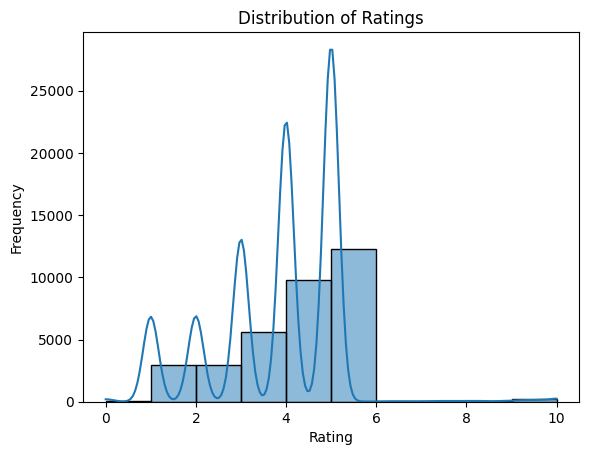

In [43]:
# Histogram Plot
sns.histplot(dfReviews['reviews.rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

TEXT LENGTH ANALYSIS:
count    34001.000000
mean       255.211641
std        215.768128
min          1.000000
25%        103.000000
50%        227.000000
75%        330.000000
max       3772.000000
Name: text.length, dtype: float64




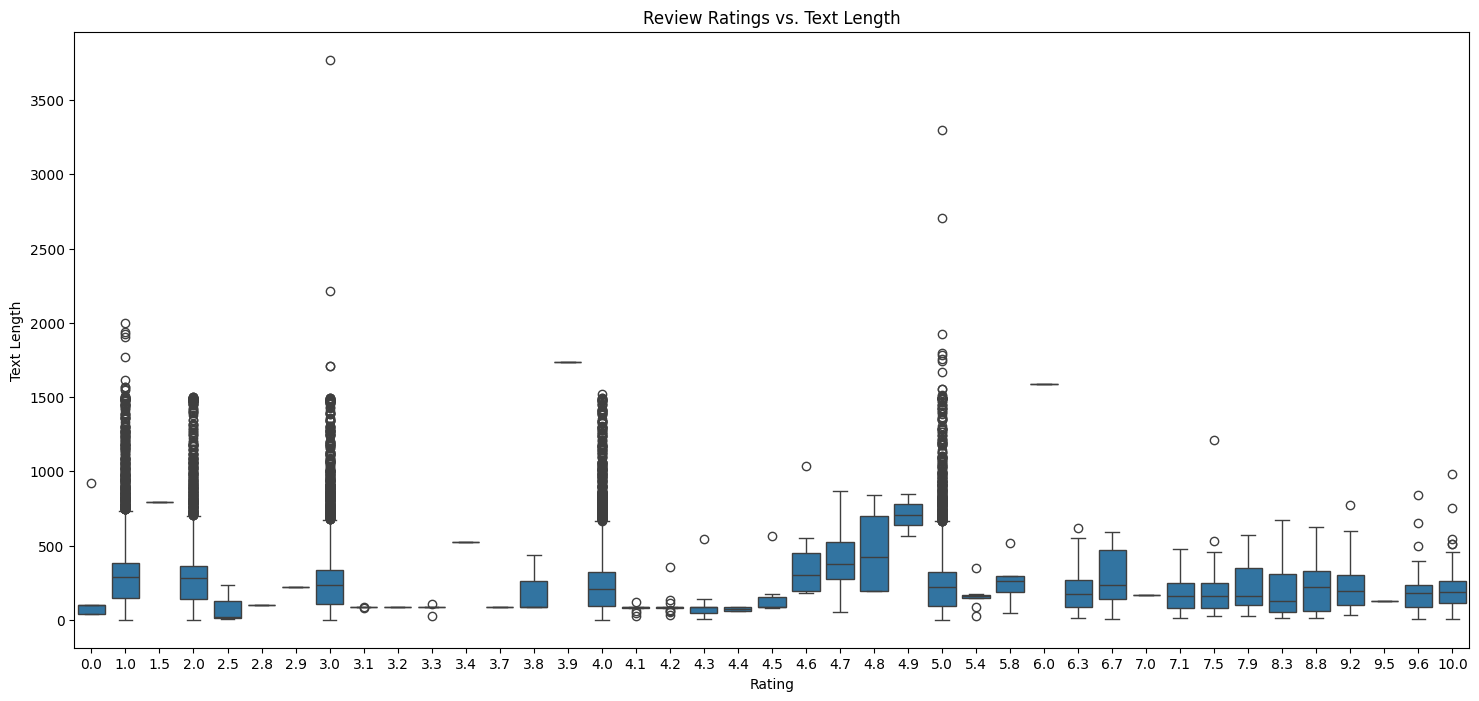

In [44]:
# Text Length Analysis
dfReviews['text.length'] = dfReviews['reviews.text'].apply(len)
print("TEXT LENGTH ANALYSIS:")
print(dfReviews['text.length'].describe())
print("\n")

# Box Plot
plt.figure(figsize=(18, 8))
sns.boxplot(x='reviews.rating', y='text.length', data=dfReviews)
plt.title('Review Ratings vs. Text Length')
plt.xlabel('Rating')
plt.ylabel('Text Length')
plt.show()

SENTIMENT ANALYSIS:
count    34001.000000
mean         0.254963
std          0.288880
min         -1.000000
25%          0.070000
50%          0.268929
75%          0.433333
max          1.000000
Name: sentiment, dtype: float64




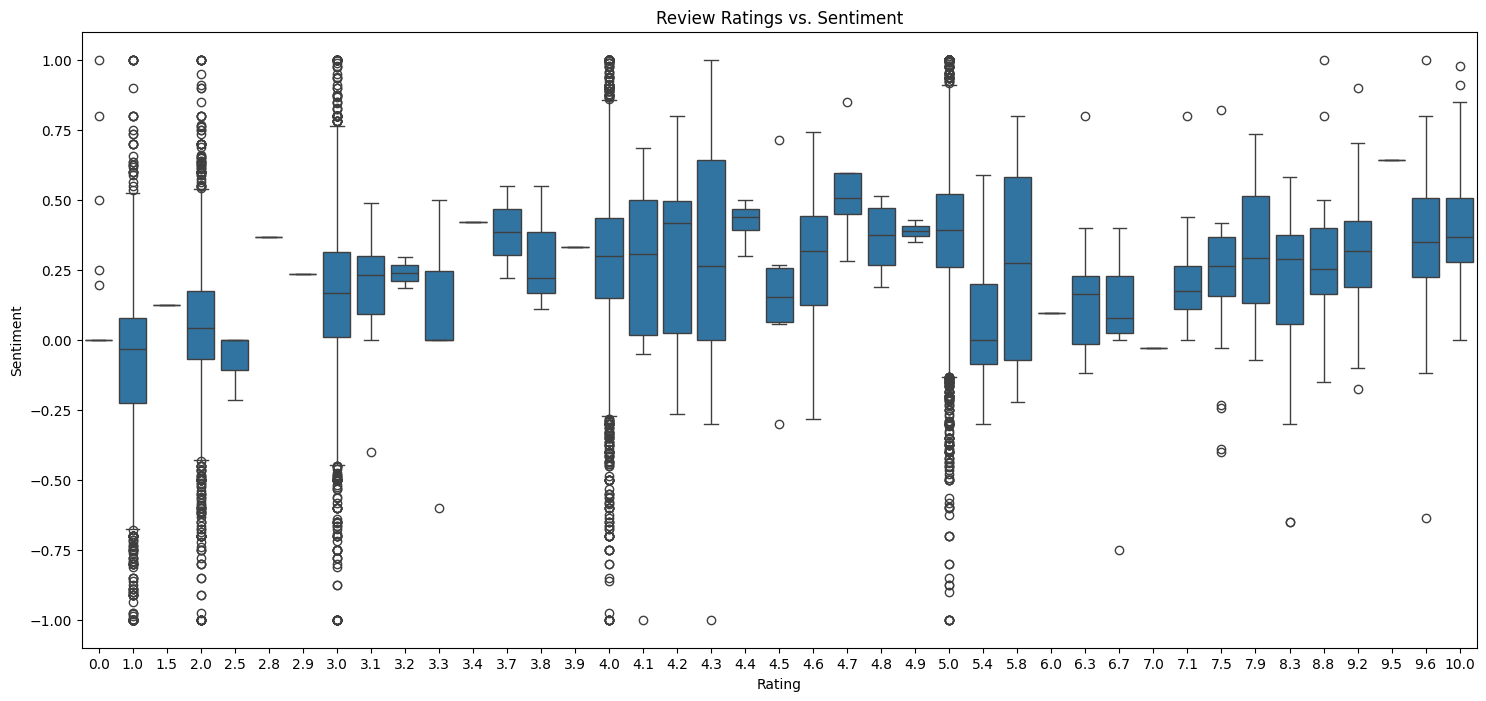

In [45]:
# Sentiment Analysis of Reviews
dfReviews['sentiment'] = dfReviews['reviews.text'].apply(lambda x: TextBlob(x).sentiment.polarity)
print("SENTIMENT ANALYSIS:")
print(dfReviews['sentiment'].describe())
print("\n")

# Box Plot
plt.figure(figsize=(18, 8))
sns.boxplot(x='reviews.rating', y='sentiment', data=dfReviews)
plt.title('Review Ratings vs. Sentiment')
plt.xlabel('Rating')
plt.ylabel('Sentiment')
plt.show()
print("\n")

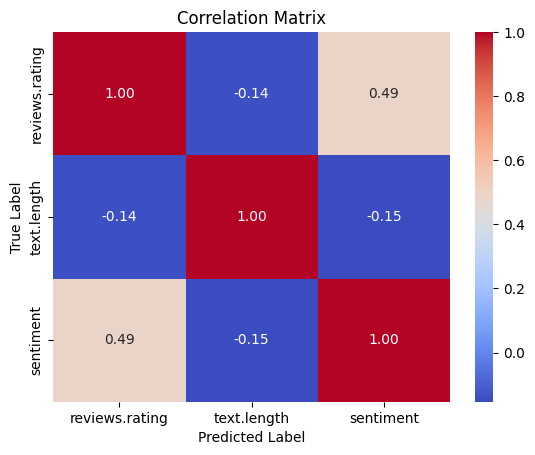

In [46]:
# Correlation Heatmap
corr_matrix = dfReviews[['reviews.rating', 'text.length', 'sentiment']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

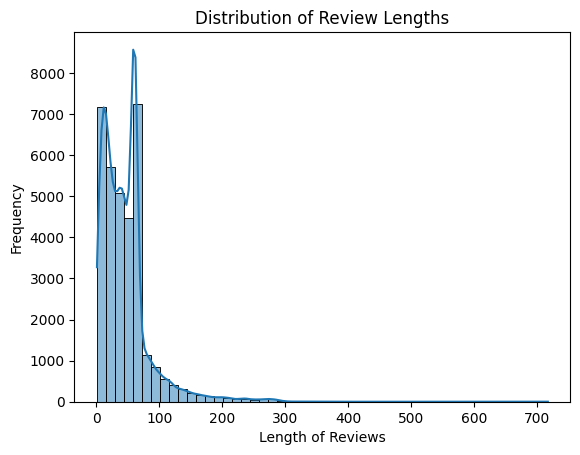

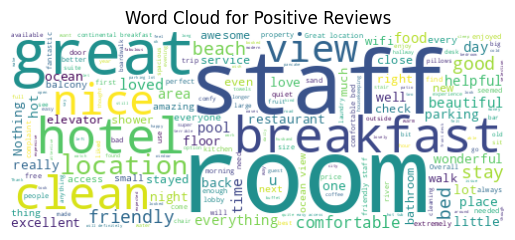

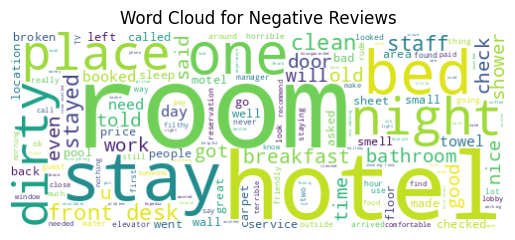

In [47]:
from wordcloud import WordCloud

# Length of Reviews
dfReviews['review.length'] = dfReviews['reviews.text'].apply(lambda x: len(x.split()))
sns.histplot(dfReviews['review.length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
plt.show()
print("\n")

# WordCloud for Positive Reviews
positive_reviews = ' '.join(dfReviews[dfReviews['reviews.rating'] > 7.0]['reviews.text'])
wordcloud = WordCloud(width=500, height=200, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()
print("\n")

# WordCloud for Negative Reviews
negative_reviews = ' '.join(dfReviews[dfReviews['reviews.rating'] < 3.0]['reviews.text'])
wordcloud = WordCloud(width=500, height=200, background_color='white').generate(negative_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

### *2.3 ~ Training the Model*

Train the model using 90% of the data

In [48]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download necessary NLTK datasets
nltk.download('stopwords')
nltk.download('wordnet')

# Function to preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

# Apply function to reviews in dataset
dfReviews['reviews.text'] = dfReviews['reviews.text'].apply(preprocess_text)

# Define X and y
X = dfReviews['reviews.text']
y = dfReviews['reviews.rating']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Load pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply BERT embeddings to training and testing data
X_train_vect = np.array([get_bert_embeddings(text, tokenizer, bert_model) for text in X_train])
X_test_vect = np.array([get_bert_embeddings(text, tokenizer, bert_model) for text in X_test])

# Normalize features
scaler = StandardScaler()
X_train_vect = scaler.fit_transform(X_train_vect)
X_test_vect = scaler.transform(X_test_vect)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noahgarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/noahgarcia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/anaconda3/envs/Tensor/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### *2.4 ~ Testing the Model*

- Test the model using the remaining 10% of the data
- The testing results will depend on the model used:
    - If the rating is evaluated as a number, look at values such as mean square error
    - If using categories, use accuracy; categories may need to be compressed to 3 categories: bad, neutral, good

In [49]:
# Linear Regression Model
model = LinearRegression()
model.fit(X_train_vect, y_train)

# Model Predictions
y_pred = model.predict(X_test_vect)

# Model Evaluation
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("ROOT MEAN SQUARE ERROR:", RMSE)

ROOT MEAN SQUARE ERROR: 1.0624612350754858


### *2.5 ~ Model Results*

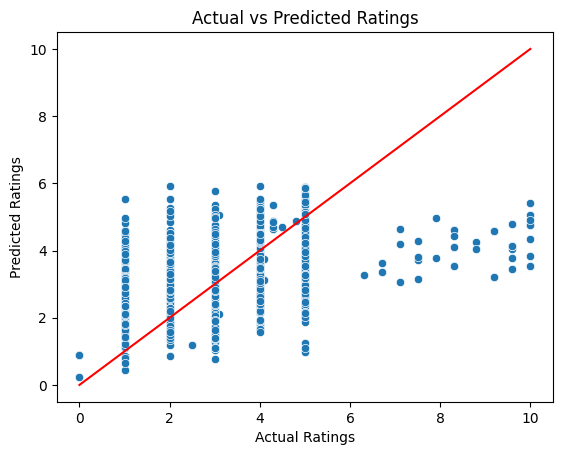

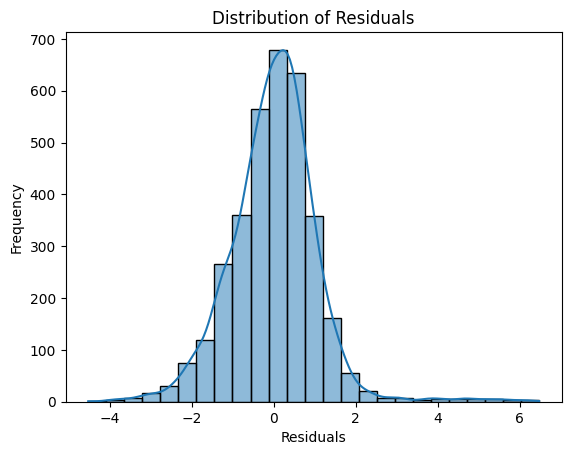

In [50]:
# Scatter Plot
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()
print("\n")

# Histogram Plot
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, bins=25)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Evidently, we need to do more in order to improve our model. We used Linear Regression and ended up with a resulting Root Mean Squared Error of around 1.0. This suggests that, on average, the predictions of our model for hotel reviews are about 1 point away from the true ratings given by customers. For example, if a hotel is given a reveiw of 4.5 points (out of 10), our model might predict that it is anywhere between 3.5 and 5.5 points. How good this value is very well depends on context, and could very well be too high or too low for some cases, so it is evident that more complex modeling and testing is needed in order to further investigate. This also implies that our model has some difficulty interpreting all of the subtle sentiments in the review texts that contribute to the ratings given by customers. Overall, an RMSE of around 1.0 indicted a moderate amount of error in our model's predictions.

### Techniques to improve the model

To improve our sentiment analysis model, we could do a variety of things. First, we could use advanced lemmatization to more accurately use context-based information and handle more complex sentiment such as negations (e.g., 'not good', 'it's okay'). A technique we left out was feature engineering, but we could also add bigrams or trigrams to capture context instead of just singular words, as well as integrating more complex features like sentence structure or grammar. Experimenting with different models such as SVMs, Random Forests, or Gradient Boosting to see how they all measure up with one another would be beneficial and allow more insights. Lastly, we could implement Cross-Validation to improve our model.